## Import the things

In [8]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
import re
import seaborn as sns

from itertools import count, cycle

from collections import OrderedDict

from scipy import interp

from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, average_precision_score, f1_score, average_precision_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import cross_val_score, ShuffleSplit, StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.svm import SVC
from sklearn.utils import compute_class_weight

from IPython.core.display import display, HTML
from IPython.display import display, Markdown

from ipywidgets import interact, IntSlider
%matplotlib inline

def printhtml(string):
    display(HTML(string))
    
state = 11

## Constants

In [3]:
ESBruce4_cols = ['ESBruce4_EP300', 'ESBruce4_H3K9ac', 'ESBruce4_H3K36me3', 'ESBruce4_H3K4me3']
E14Tg2a4_cols = ['E14Tg2a4_POU5F1', 'E14Tg2a4_NANOG', 'E14Tg2a4_H3K27me3']
metadata_cols = ['attempt.number', 'Gene', 'trials', 'mutation', 'guide_sequence', 'File', 'comments.1', 'comments.2']
nhej_cols = ['indels', 'indel.ratio']
coordinate_cols = ['chromosome', 'start.position', 'end.position']
external_cols = ['sgRNAscorer.Mm', 'WU_CRISPR']


rev = {'A':'T', 'T':'A', 'C':'G', 'G':'C', 'a':'t', 't':'a', 'c':'g', 'g':'c'}

nucleotides = ['A', 'T', 'C', 'G']
dinucleotides = [i + j for i in nucleotides for j in nucleotides]
trinucleotides = [i + j + k for i in nucleotides for j in nucleotides for k in nucleotides]

allnucleotides = nucleotides + dinucleotides + trinucleotides

colour_pool = ['#EE3224', '#F78F1E', '#FFC222', '#FFCC00', '#EE3224', '#F78F1E', '#FFC222', '#FFCC00', '#EE3224', '#F78F1E', '#FFC222', '#FFCC00', '#EE3224', '#F78F1E', '#FFC222', '#FFCC00']

In [689]:
file_name = 'data/Gaetan.featureTable.2.xlsx'
#file_name = 'data/Gaetan.featureTable_allDupsRemoved.xlsx'

50

## Functions

In [705]:
def read_data(file_name):
    df = pd.read_excel(file_name, index_col='Id')
    df.WU_CRISPR.fillna(0, inplace=True)
    df = df[pd.notnull(df['ss_oligo'])]
    df.shape
    return df


def reverse_complement(sequence):
    return ''.join([rev[i] for i in sequence[::-1]])


def get_arm(guide, oligo, distance_from_pam, mutation_size, strand):
    pam_mutation_index = range(20 - distance_from_pam - mutation_size, 20 - distance_from_pam)
    guide_regex = ''.join([nucleotide if i not in pam_mutation_index else '[ATCG]' for i, nucleotide in enumerate(guide)])
    match = re.search(guide_regex, oligo, flags=re.IGNORECASE)
    if match:
        dist = match.span()[1] - distance_from_pam - 3
        arms = [oligo[: dist-1], oligo[dist:]]
    else:
        oligo = reverse_complement(oligo)
        match = re.search(guide_regex, oligo, flags=re.IGNORECASE)
        dist = match.span()[1] - distance_from_pam - 3
        arms = [oligo[: dist-1], oligo[dist:]]
    return arms[0], arms[1]

def get_arm_length(guide, oligo, distance_from_pam, mutation_size, strand):
    arms = get_arm(guide, oligo, distance_from_pam, mutation_size, strand)
    return [len(i) for i in arms]

def get_plus_oligo(guide, oligo, distance_from_pam, mutation_size, strand):
    pam_mutation_index = range(20 - distance_from_pam - mutation_size, 20 - distance_from_pam)
    guide_regex = ''.join([nucleotide if i not in pam_mutation_index else '[ATCG]' for i, nucleotide in enumerate(guide)])
    match = re.search(guide_regex, oligo, flags=re.IGNORECASE)
    if match:
        return oligo
    oligo = reverse_complement(oligo)
    match = re.search(guide_regex, oligo, flags=re.IGNORECASE)
    if match:
        return oligo        
    
def score_data(rf, X, y):
    score = rf.score(X, y)
    print(score)

    
def plot_nucleotides(data, importances, index):
    width = 1/(len(index)+1)
    pos = range(len(data[index[0]]))
    colours = {single_index[i]: colour_pool[i] for i in range(len(single_index))}
    plt.rcdefaults()
    plt.style.use('ggplot')
    fig, ax = plt.subplots()
    for i, s in enumerate(index):
        print(importances[data[s]])
        plt.bar([p + width * i for p in pos], importances[data[s]], width, alpha=0.5, color=colours[s], label=s)
    ax.set_ylabel('Gini impurity')
    #ax.set_ylim([0,0.06])
    ax.set_xticks([p + 2 * width for p in pos])
    ax.set_xticklabels([X_train.columns[i].split('_')[1] for i in data[index[0]]])
    #ax.set_xticklabels([i for i in data[index[0]]])
    ax.set_title('Feature importances for {} ({},{})'.format(y.name, split_state, state))
    plt.legend(index, loc='upper right')
    plt.show()


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def merge_duplicates(df, merge_key):
    tmp_df = df.reset_index().groupby(merge_key, group_keys=False).agg(
        {'Id': 'first',
         'point_mutations':sum,
         'indels': sum,
         'trials': sum}).set_index('Id')
    cols_to_use = df.columns.difference(tmp_df.columns)

    merged_df = pd.concat([df[cols_to_use], tmp_df], axis=1, join='inner')
    return merged_df


def filter_olds(df, cutoff_date):
    return df[ df.Date > cutoff_date]

def filter_news(df, cutoff_date):
    return df[ df.Date < cutoff_date]

def remove_unwanted(df, vaa):
    #df3 = df[ ~(df.point_mutations / df.trials).between(range_from, range_to, True)]
    df = df[ (df.indels / df.trials) > vaa]
    #wanted_df = df
    return df

def remove_dodgy(df):
    df = df[df.dodgy == 0]
    return df

def process_labels(df, hdr_threshold):

    range_from = 0.25
    range_to = 0.75
    
    labels_df = df.loc[:, ['indels', 'point_mutations', 'trials', 'New']]

    labels_df.loc[:, 'nhej'] = (labels_df.loc[:, 'indels'] / labels_df.loc[:, 'trials']) > 0.5

    #labels_df.loc[:, 'hdr'] = (labels_df.point_mutations / labels_df.trials) > ((range_to + range_from) / 2)
    labels_df.loc[:, 'hdr'] = (labels_df.point_mutations / labels_df.trials) > hdr_threshold
    labels_df.loc[:, 'hdr_ratio'] = (labels_df.point_mutations / labels_df.trials)
    #labels_df.loc[:, 'hdr'] = (labels_df.point_mutations / labels_df.trials) > 0.15
    
    
    
    #labels_df.loc[:, 'hdr'] = (labels_df.point_mutations > 0)

    print('High', labels_df.hdr[labels_df.hdr == 1].count())
    print('Low', labels_df.hdr[labels_df.hdr == 0].count())

    print ((labels_df.point_mutations / labels_df.trials).median())

    #Reindex
    labels_df=labels_df.reset_index().set_index(['New','Id']).sort_index()
    return labels_df


def process_features(df):
    # Specify PAM length (3 for Cas9)
    LENGTH_OF_PAM = 3
    
    continuous_features = ['distance_from_pam']
    
    # Nucleotide blocks to capture?
    prefixes = {'n': 1, 'di': 2}
    
    # Get all the other single/di/tri nucleotide combinations
    guide_local_df = pd.DataFrame(data=None, index=df.index)
    for pre in prefixes:
        l = prefixes[pre] - 1
        for i in range(1,21 - l):
            guide_local_df.loc[:, 'g_{}_{:02d}'.format(pre, i)] = df.full_guide_sequence.str[- LENGTH_OF_PAM - i - l: - LENGTH_OF_PAM - i + 1]
    
    guide_global_df = guide_local_df.apply(pd.Series.value_counts, axis=1).fillna(0).astype(np.int8)


    # Get the N from the PAM and the adjacent nucleotide 
    guide_local_df.loc[:, 'N'] = df.full_guide_sequence.str[- LENGTH_OF_PAM]
    guide_local_df.loc[:, 'o1'] = df.o1
    
    tokens_AT_CG = [
        #(3, 'CCG|CGG|GGC|GCC|CGC|GCG|CCC|GGG'), (3, 'AAT|ATT|TTA|TAA|ATA|TAT|AAA|TTT'),
        (2, 'AT|TA|AA|TT'), (2, 'CG|GC|CC|GG'),
        (1, 'G|C'), (1, 'A|T')
    ]
    
    tokens = [
        #(3, 'CCG|CGG|GGC|GCC|CGC|GCG'), (3, 'CCC|GGG'), (3, 'AAT|ATT|TTA|TAA|ATA|TAT'), (3, 'AAA|TTT'),
        (2, 'TA'), (2, 'CG'), (2, 'AA'), (2, 'CC'), (2, 'AT'), (2, 'GC'), (2, 'TT'), (2, 'GG'),
        (1, 'C'), (1, 'T'), (1, 'G'), (1, 'A')
    ]
    
    tokens = tokens_AT_CG
    
    df.loc[:, 'plus_oligo'] = np.vectorize(get_plus_oligo)(df.full_guide_sequence, df.ss_oligo, df.distance_from_pam, df.mutation_size, df.strand)
    
    
    
    #Oligo
    oligo_global_df = pd.DataFrame(data=None, index=df.index)
    for i in tokens:
        oligo_global_df.loc[:, '{}'.format(i[1])] = df.plus_oligo.apply(
            lambda x: round(len(re.findall('(?={})'.format(i[1]), x, flags=re.IGNORECASE)) / (len(x)/i[0]) * 100)
        )
        
        
    oligo_arm_df = df.apply(
        lambda _: pd.Series(
            get_arm_length(_.full_guide_sequence, _.plus_oligo, _.distance_from_pam, _.mutation_size, _.strand),
            index=[['arm1','arm2']]),
            axis=1
    )
    
    tokens_patterns = [
        (2, r'(.{2})\1+'),
        (3, r'(.{3})\1+'),
        (4, r'(.{4})\1+'),
        (5, r'(.{5})\1+')
    ]
    repeats_df = pd.DataFrame(data=None, index=df.index)
    for i in tokens_patterns:
        repeats_df.loc[:, 'rep_{}'.format(i[0])] = df.full_guide_sequence.apply(
            lambda x: len(re.findall('{}'.format(i[1]), x, flags=re.IGNORECASE)) / (len(x)/i[0]) * 100
        )

        
    # Do we want dummies?
    #guide_local_df = pd.get_dummies(guide_local_df).astype(np.int8)
    # Or just integer encoding
    #print(guide_local_df)
    le = LabelEncoder()
    #le.fit(allnucleotides)
    for column_name in guide_local_df.columns:
        guide_local_df.loc[:, column_name] = le.fit(allnucleotides).transform(guide_local_df[column_name])
    

    # Order sequentially for the plotting
    #cols = list(features_df.columns.values)
    #cols.sort(reverse = True)
    #features_df = features_df[cols]
    
    # Merge with continuous features
    
    #features_df = pd.concat([guide_global_df], axis=1)
    #features_df = pd.concat([df.loc[:, continuous_features], guide_global_df], axis=1)
    
    #features_df = pd.concat([oligo_global_df], axis=1)
    features_df = pd.concat([df.loc[:, continuous_features], oligo_global_df], axis=1)
    
    #features_df = pd.concat([df.loc[:, continuous_features], oligo_global_df, repeats_df], axis=1)
    #features_df = pd.DataFrame()

    # One hot
    #enc = OneHotEncoder()
    #features_df = enc.fit_transform(features_df)
    
    # Add the column for new features (could also be a date maybe)
    features_df.loc[:, 'New'] = df.New
    #features_df.loc[:, 'does_cut'] = (df.indels / df.trials) > 0.5
    
    #Reindex
    features_df = features_df.reset_index().set_index(['New','Id']).sort_index()
    return features_df

## Variables

In [706]:
hdr_threshold = 0.2
RANDOM_STATE = 3463767
N_TREES = 2000
CV_FOLDS = 4
CV = StratifiedKFold(CV_FOLDS)
#CV = ShuffleSplit(CV_FOLDS, train_size=0.8, test_size = 0.2, random_state=35236)




## Create dataframes

In [707]:
df = read_data(file_name)
df = filter_news(df, '2017/10/10')
df = merge_duplicates(df, 'ss_oligo')
df = remove_unwanted(df, 0.4)
df = remove_dodgy(df)
#df = df.loc[[0, 1], :]
labels_df = process_labels(df, hdr_threshold=hdr_threshold)

features_df = process_features(df)

#Define final DFs (X and y)
X = features_df.loc[[0, 1], :]
y = labels_df.hdr.loc[[0, 1], :]

print('High', len(y[y == True]))
print('Low', len(y[y == False]))

features_df

High 16
Low 16
0.19871794871794873
High 12
Low 15


distance_from_pam  AT|TA|AA|TT  CG|GC|CC|GG  G|C  A|T
New Id                                                                      
0   ARPC1B_W104S_1                    12           27           70   61   39
    BTLA_L161F_1                       2           40           44   51   49
    CCNF_S621G_1                       4           15           65   62   38
    DHX58_H314C_1                     12           35           49   54   46
    IL21R_S489R_1                      8           18           60   61   39
    IRF4_T59R_1                       10           48           36   47   53
    IRF4_T59R_2                       10           48           36   47   53
    MDM2_C303F_1                      -5           63           30   42   58
    MEK_M143C_3                        7           20           62   60   40
    NFKB2_D864G_1                      9           15           62   61   39
    OTUD7B_A303T_1                    30           38           45   52   48
    PRDM1_P403S_1                      9           42           59   54   46
    PTPN22_R619W_1                     4           53           37   46   54
    PTPN22_S687C_1                    -4           66           23   39   61
    RNF43_P154L_1                      4           31           49   55   46
    RYR2_V4651F_2                      3           81           17   34   66
    RYR2_Y2932H_1                      3           45           40   49   51
    VPS51_R78P_7                      14           28           48   55   45
    ZFR2_A704T_1                       5           27           56   57   43
1   EFL1_R1102Q_1                      4           45           52   52   48
    MAN2A1_C115S_1                     6           20           68   62   38
    RC3H1_F225S_1                      2           41           44   51   49
    RC3H1_H46P_1                       5           49           43   49   51
    SRCAP_Arg2435_1                   20           23           57   59   41
    SSBP4_A341G_1                      6           15          115   75   25
    STAT4_P450S_2                      8           70           27   39   61
    STAT4_P450S_4                      8           66           31   41   59
2   CD79B_Y195H_1                      3           33           52   55   45
    IFIT3_K374Q_1                      4           45           39   48   52
    IFIT3_K374R_1                      4           45           41   49   51
    LAT2_G33V_1                       15           34           59   57   43
    TNFRSF13B _C76R_1                  5           13           67   63   37

## Define model parameters

In [708]:
class_weights = dict(zip(np.unique(y), compute_class_weight('balanced', np.unique(y), y)))

#forest = SVC(kernel='linear', probability=True, random_state=RANDOM_STATE)
forest = RandomForestClassifier(
    n_estimators=N_TREES,
    oob_score=True,
    random_state=RANDOM_STATE,
    class_weight = class_weights,
    n_jobs=2
)

#forest = RandomForestClassifier(n_estimators=1000, oob_score=True, max_features="sqrt", max_depth=8, random_state=state)

## Split the data and build the models for cross validation

In [709]:
oob_scores = []

def get_train_test_arrays(cv):
    return [fold for fold in cv.split(X, y)]

def train_model(itrain):
    forest.fit(X.iloc[itrain, :], y.iloc[itrain])
    oob_scores.append(forest.oob_score_)
    print('Score: {}'.format(forest.oob_score_))

def get_probs(itest):
    probabilities = forest.predict_proba(X.iloc[itest, :])
    return probabilities

def get_preds(itest):
    predictions = forest.predict(X.iloc[itest, :])
    return predictions

def train_and_test(fold):
    train_model(fold[0])
    return get_probs(fold[1])

def train_and_dec(fold):
    train_model(fold[0])
    return forest.oob_decision_function_ 
    
folds = get_train_test_arrays(cv)
test_folds = [fold[1] for fold in folds]
train_folds = [fold[0] for fold in folds]

probs = [train_and_test(fold) for fold in folds]

print('Average score:')
np.mean(oob_scores)

Score: 0.65
Score: 0.6
Score: 0.65
Score: 0.5238095238095238
Average score:


0.60595238095238091

## Print common metrics

In [710]:
def print_model_metrics(truths, preds):
    print('preci:  {0:0.2f}'.format(precision_score(truths, preds)))
    print('recall: {0:0.2f}'.format(recall_score(truths, preds)))
    print('f1:     {0:0.2f}'.format(f1_score(truths, preds)))

def print_confusion_matrix(truths, preds):
    cnf_matrix = confusion_matrix(truths, preds)
    print(cnf_matrix)

def print_predictions(truths, preds, probs):
    for i in range(0,len(truths)):
        print(truths.index[i][1], truths.iloc[i], probs[:, 1][i], preds[i])


for (p, itest, i) in zip(probs, test_folds, count()):
    truths = y.iloc[itest]
    preds = p[:, 1] > 0.50
    print('ROC fold {}'.format(i))
    print_confusion_matrix(truths, preds)
    print_model_metrics(truths, preds)
    print_predictions(truths, preds, p)
    print('')

ROC fold 0
[[1 3]
 [1 2]]
preci:  0.40
recall: 0.67
f1:     0.50
ARPC1B_W104S_1 False 0.3825 False
BTLA_L161F_1 False 0.865 True
CCNF_S621G_1 True 0.5545 True
DHX58_H314C_1 False 0.5055 True
IL21R_S489R_1 True 0.3075 False
IRF4_T59R_1 False 0.936 True
IRF4_T59R_2 True 0.936 True

ROC fold 1
[[4 0]
 [1 2]]
preci:  1.00
recall: 0.67
f1:     0.80
MDM2_C303F_1 False 0.178645400675 False
MEK_M143C_3 False 0.365 False
NFKB2_D864G_1 True 0.800704188828 True
OTUD7B_A303T_1 False 0.476479091345 False
PRDM1_P403S_1 True 0.394659590645 False
PTPN22_R619W_1 True 0.635960105275 True
PTPN22_S687C_1 False 0.101142761693 False

ROC fold 2
[[3 1]
 [1 2]]
preci:  0.67
recall: 0.67
f1:     0.67
RNF43_P154L_1 False 0.340589133089 False
RYR2_V4651F_2 False 0.0520495264969 False
RYR2_Y2932H_1 True 0.867443337281 True
VPS51_R78P_7 True 0.0527867729106 False
ZFR2_A704T_1 False 0.345192307692 False
EFL1_R1102Q_1 True 0.780023767169 True
MAN2A1_C115S_1 False 0.6575 True

ROC fold 3
[[3 0]
 [1 2]]
preci:  1.00
r

## Plot ROC curve(s)

[ 0.38  0.86  0.55  0.51  0.31  0.94  0.94]
[ 0.18  0.36  0.8   0.48  0.39  0.64  0.1 ]
[ 0.34  0.05  0.87  0.05  0.35  0.78  0.66]
[ 0.25  0.76  0.32  0.56  0.21  0.28]


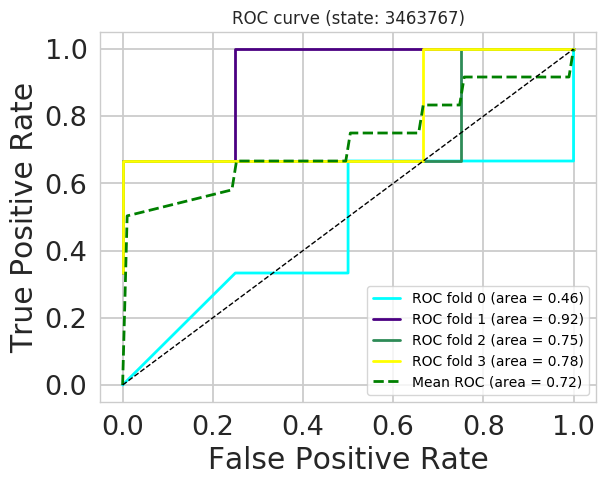

0.577854358118
0.47619047619
0.916666666667
0.833333333333
0.866666666667


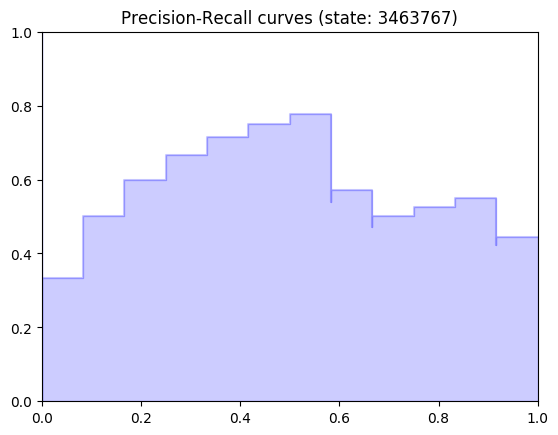

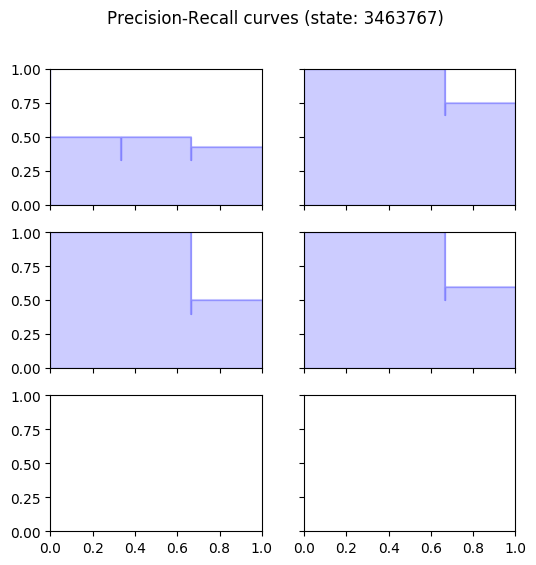

In [711]:
print_roc_plot(probs, test_folds)

forest.fit(X, y)
a = forest.oob_decision_function_
print_prec_rec_plots(a)

print_many_prec_rec_plots(probs, test_folds)

In [612]:
def print_many_prec_rec_plots(decs, tf):
   

    fig, ax = plt.subplots(nrows=3, ncols=2,
                    sharex=True, sharey=True,
                    figsize=(6,6))
    plt.rcdefaults()
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    for (p, t, a, i) in zip(decs, tf, [item for sublist in ax for item in sublist], count()):
        average_precision = average_precision_score(y.iloc[t], p[:, 1])
        print(average_precision)
        precision, recall, thresholds = precision_recall_curve(y.iloc[t], p[:, 1])
        a.step(recall, precision, color='b', alpha=0.2, where='post')
        a.fill_between(recall, precision, step='post', alpha=0.2, color='b')    
    #plt.subplots_adjust(top=1, bottom=0, left=0.10, right=0.95, hspace=0.4,
    #    wspace=0.35)
    plt.suptitle('Precision-Recall curves (state: {})'.format(RANDOM_STATE))

def print_prec_rec_plots(decs):
    plt.rcdefaults()
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    average_precision = average_precision_score(y, decs[:, 1])
    print(average_precision)
    precision, recall, thresholds = precision_recall_curve(y, decs[:, 1])
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')    
    plt.title('Precision-Recall curves (state: {})'.format(RANDOM_STATE))
    
def print_roc_plot(probs, test_folds):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)   
    line_width = 2
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
    sns.set('talk', 'whitegrid', 'dark', font_scale=1.5,
            rc={"lines.linewidth": 1, 'grid.linestyle': '-'})
    
    for (p, t, c, i) in zip(probs, test_folds, colors, count()):
        fpr, tpr, thresholds = roc_curve(y.iloc[t], p[:, 1])
        print(p[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=line_width, color=c,
            label='ROC fold {} (area = {:0.2f})'.format(i, roc_auc))
    
    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[0], mean_tpr[-1] = 0.0, 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
        label='Mean ROC (area = {:0.2f})'.format(mean_auc), lw=line_width)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.rcdefaults()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (state: {})'.format(RANDOM_STATE))
    plt.legend(loc="lower right")
    plt.show()

## Plot OOB error

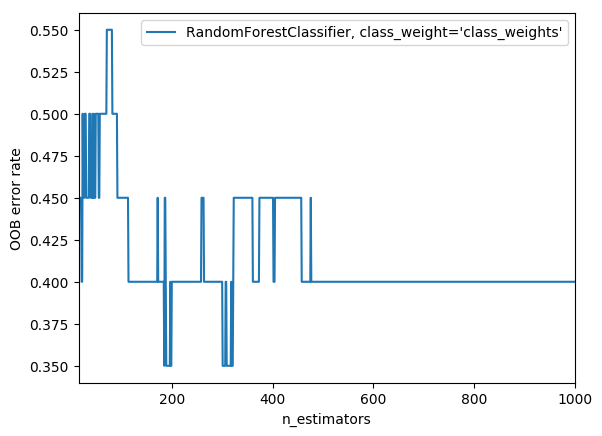

In [474]:
# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, class_weight='class_weights'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE,
                               class_weight = class_weights)),
#    ("RandomForestClassifier, class_weight='none'",
#        RandomForestClassifier(warm_start=True, oob_score=True,
#                               max_features="sqrt",
#                               random_state=RANDOM_STATE)),
    
]


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 1000

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [455]:
X = features_df.loc[[0], :]
y = labels_df.hdr.loc[[0], :]

rf = forest.fit(X, y)

X_test = features_df.loc[[1], :]
y_truth = labels_df.hdr.loc[[1], :]
y_pred_probs = rf.predict_proba(X_test)

print(y_truth)
fpr, tpr, thresholds = roc_curve(y_truth, y_pred_probs[:, 1])
auc(fpr, tpr)


New  Id             
1    EFL1_R1102Q_1       True
     RC3H1_F225S_1       True
     SRCAP_Arg2435_1    False
     SSBP4_A341G_1       True
     STAT4_P450S_4      False
Name: hdr, dtype: bool


0.0

Accuracy: 0.4

               precision    recall  f1-score   support

 Low activity       0.00      0.00      0.00         2
High activity       0.50      0.67      0.57         3

  avg / total       0.30      0.40      0.34         5

Confusion matrix, without normalization
[[0 2]
 [1 2]]
Normalized confusion matrix
[[ 0.    1.  ]
 [ 0.33  0.67]]


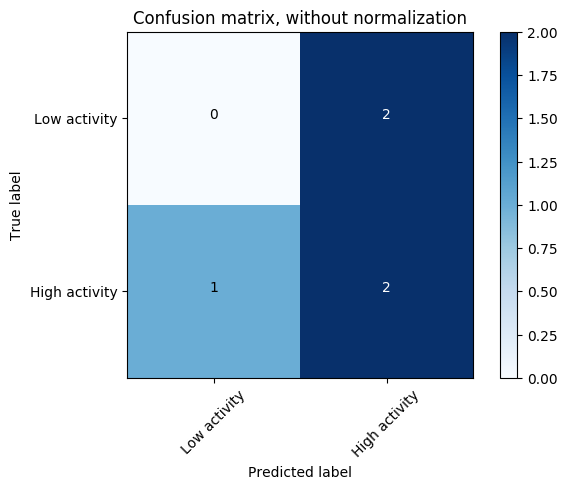

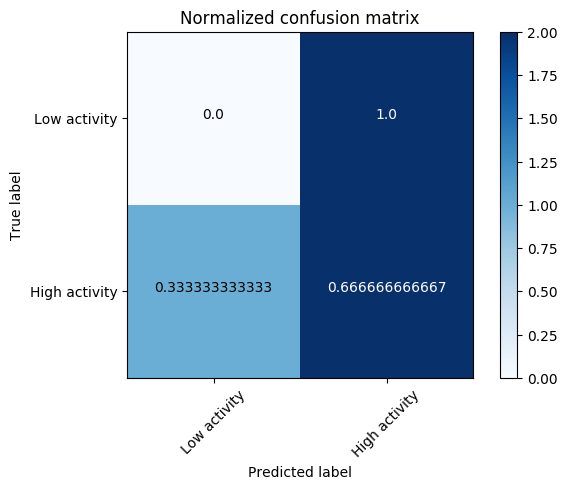

In [456]:
X = features_df.loc[[0], :]
y = labels_df.hdr.loc[[0], :]

rf = forest.fit(X, y)

X_test = features_df.loc[[1], :]
y_truth = labels_df.hdr.loc[[1], :]

y_pred = rf.predict(X_test)

print('Accuracy: {}\n'.format(rf.score(X_test, y_truth)))

target_names = ['Low activity', 'High activity']
print(classification_report(y_truth, y_pred, target_names=target_names))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_truth, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Cross validation

In [ ]:
rs1=58898
rs2=1981

X = features_df
y = labels_df.hdr
forest = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=87675879)
cv = ShuffleSplit(test_size=0.2, random_state=1166)
cv = StratifiedKFold(5)
scores = cross_val_score(forest, X, y, cv=cv)
print(np.mean(scores))
print(scores)

## Build model on entire dataset for feature inspection

In [457]:
test_size = 0.2
X = features_df
y = labels_df.hdr
y2 = labels_df.nhej

X_train, X_test, y_train, y_test = train_test_split(X, labels_df.hdr, test_size=test_size, random_state=state)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, labels_df.nhej, test_size=test_size, random_state=state)

n_estimator = 1000
rf = RandomForestClassifier(n_estimators=n_estimator, oob_score=True, random_state=state)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=11, verbose=0, warm_start=False)

In [458]:
importances = rf.feature_importances_

mean = np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
minvals = np.min([tree.feature_importances_ for tree in rf.estimators_], axis=0)
maxvals = np.max([tree.feature_importances_ for tree in rf.estimators_], axis=0)
percent25 = np.percentile([tree.feature_importances_ for tree in rf.estimators_], 25, axis=0)
percent75 = np.percentile([tree.feature_importances_ for tree in rf.estimators_], 75, axis=0)

indices = np.argsort(importances)[::-1]
unindices = range(0, len(importances))

diff_25 = np.array(list(map(operator.sub, percent25, importances)))
diff_75 = np.array(list(map(operator.sub, percent75, importances)))


## Print a list of the important features

In [459]:
#@interact(how_many=(10,20,10))
def f(how_many):
    o = ['<li>{} ({})'.format(X.columns[i], importances[i]) for i in indices][0:how_many]
    printhtml('<h4>Feature ranking:</h4><ol type="1">' +''.join(o))
f(100)

## Plot the important features

NameError: name 'split_state' is not defined

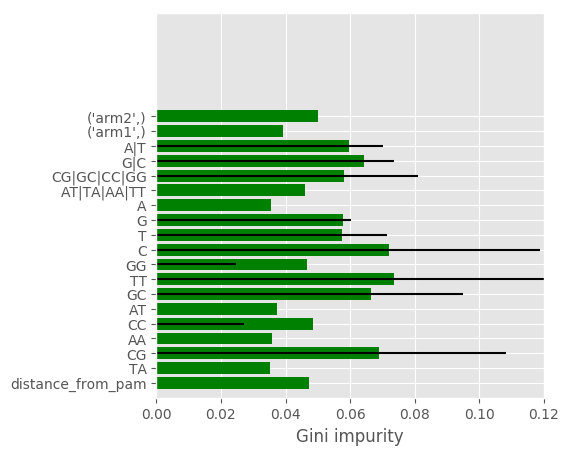

In [460]:
@interact(a=IntSlider(min=0, max=len(unindices)-10, step=25, value=0, continuous_update=False))
def plot_importances(a):
    how_many = len(unindices)
    plt.rcdefaults()
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.barh(np.arange(how_many), importances[unindices][0:how_many], xerr=[importances[unindices][0:how_many], diff_75[unindices][0:how_many]],
           color='green', align='center')
    ax.set_xlabel('Gini impurity')
    ax.set_yticks(np.arange(how_many))
    ax.set_yticklabels([X_train.columns[i] for i in unindices][0:how_many])
    ax.set_xlim([0,0.12])
    ax.set_ylim([-1+a,25+a])
    #ax.invert_yaxis()
    ax.set_title('Feature importances for {} ({},{})'.format(y.name, split_state, state))
    plt.show()

In [ ]:
single_index = ['A', 'T', 'C', 'G']
#single_index = ['AA', 'AT', 'AC', 'AG', 'TA', 'TT', 'TC', 'TG', 'CA', 'CT', 'CC', 'CG', 'GA','GT','GC','GG']
#single_index = ['']

clustered = {s:[j[0] for j in enumerate(X.columns) if j[1].startswith('n') and j[1].endswith(s)] for s in single_index}


split_state = 15125
X = features_df
y = labels_df.hdr
y = labels_df.point_mutations >= 1

X_train, X_test, y_train, y_test = train_test_split(X, labels_df.hdr, test_size=test_size, random_state=split_state)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, labels_df.nhej, test_size=test_size, random_state=split_state)


rf = RandomForestClassifier(n_estimators=2500, oob_score=True, random_state=5856)

#y = df.hdr
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=36346)
rf.fit(X, y)
importances = rf.feature_importances_
print([len(clustered[i]) for i in clustered])

print(importances)
plot_nucleotides(clustered, importances, single_index)

#rf.fit(X_train, y_train)
#importances = rf.feature_importances_
#plot_nucleotides(clustered, single_index)


#y = df.nhej
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=11)
#rf.fit(X_test, y_test)
#importances = rf.feature_importances_
#plot_nucleotides(clustered, single_index)

#rf.fit(X_train, y_train)
#importances = rf.feature_importances_
#plot_nucleotides(clustered, single_index)

#y = df.hdr
#rf.fit(X, y)
#importances = rf.feature_importances_
#clustered = {s:[j[0] for j in enumerate(X_test.columns) if j[1].startswith('n') and j[1].endswith(s)] for s in single_index}
#plot_nucleotides(clustered, importances, single_index)

#y = df.nhej
#rf.fit(X, y)
#importances = rf.feature_importances_
#clustered = {s:[j[0] for j in enumerate(X_test.columns) if j[1].startswith('n') and j[1].endswith(s)] for s in single_index}
#plot_nucleotides(clustered, importances, single_index)


y = labels_df.point_mutations >= 1
all_the_importances = {}
def train_n_plot(state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=state)
    #train on half
    rf.fit(X_test, y_test)
    importances = rf.feature_importances_
    
    
    clustered = {s:[j[0] for j in enumerate(X_test.columns) if j[1].startswith('di') and j[1].endswith(s)] for s in single_index}
    plot_nucleotides(clustered, importances, single_index)
    
    
    
    imp_dict = {X.columns[i]: importances[i] for i in range(0, len(importances))}
    for i in imp_dict:
        if i in all_the_importances:
            all_the_importances[i] = all_the_importances[i] + imp_dict[i]
        else:
            all_the_importances[i] = imp_dict[i]
            
    #train on the other half
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    clustered = {s:[j[0] for j in enumerate(X_train.columns) if j[1].startswith('di') and j[1].endswith(s)] for s in single_index}
    plot_nucleotides(clustered, importances, single_index)
    imp_dict = {X.columns[i]: importances[i] for i in range(0, len(importances))}
    for i in imp_dict:
        if i in all_the_importances:
            all_the_importances[i] = all_the_importances[i] + imp_dict[i]
        else:
            all_the_importances[i] = imp_dict[i]
    

        
#for i in [36346, 11, 1376431, 644373]:
#for i in [111]:
#    train_n_plot(i)

#print(all_the_importances)

In [ ]:
ensemble_clfs = [
    ("RandomForestClassifier",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=state)),
    ("RandomForestClassifier2",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               max_depth=3,
                               random_state=state))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 100

for label, clf in ensemble_clfs:
    
    
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))        

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [ ]:
labels_df.loc[:, 'hdr'] = (labels_df.point_mutations / labels_df.trials) > ((range_to + range_from) / 2)
labels_df.loc[:, 'hdr'] = (labels_df.point_mutations / labels_df.trials) > (0.06)

X_train = features_df.xs(0)
y_train = labels_df.xs(0).hdr

X_test = features_df.xs(1)
y_test = labels_df.xs(1).hdr


#X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df.hdr, test_size=0.2, random_state=68666)

#forest = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=8496458)
probas_ = forest.fit(X_train, y_train).predict_proba(X_test)
probas_

labels_df

cnf_matrix = confusion_matrix(y_test, probas_[:, 1] > 0.5)
print(cnf_matrix)


print(forest.fit(X_train, y_train).predict(X_test))

for a in nucleotides:
    print(a)
    b = np.mean(features_df.loc[labels_df.hdr == True, :].xs(0)[a]) - np.mean(features_df.loc[labels_df.hdr == True, :].xs(1)[a])
    c = np.mean(features_df.loc[labels_df.hdr == True, :].xs(0)[a]) - np.mean(features_df.loc[labels_df.hdr == False, :].xs(0)[a])
    print(b < c)

features_df.loc[labels_df.hdr == True, :].xs(0)



In [ ]:
import re
cellLine_re = re.compile(r"""^E[0-9]{3}$""")


cellLine_re.match('E999')


In [ ]:
GEN_CHROMS = {'grch37': ['1','2','3','4']}


'grch37' in GEN_CHROMS

In [ ]:
sns.set(style="dark")
rs = np.random.RandomState(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rs.randn(2, 50)
    
    sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=ax)
    
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()

In [554]:
def get_arm_length(guide, oligo, distance_from_pam, mutation_size, strand):
    pam_mutation_index = range(20 - distance_from_pam - mutation_size, 20 - distance_from_pam)
    guide_regex = ''.join([nucleotide if i not in pam_mutation_index else '[ATCG]' for i, nucleotide in enumerate(guide)])
    match = re.search(guide_regex, oligo, flags=re.IGNORECASE)
    if match:
        dist = match.span()[1] - distance_from_pam - 3
        arms = [oligo[: dist-1], oligo[dist:]]
    else:
        oligo = reverse_complement(oligo)
        match = re.search(guide_regex, oligo, flags=re.IGNORECASE)
        dist = match.span()[1] - distance_from_pam - 3
        arms = [oligo[: dist-1], oligo[dist:]]
    print(arms)
    return arms[0], arms[1]


guide = 'TTCTCTCACAGGGCTGCATTGGG'
oligo = 'AGCAAACCACACTCCTGTCACATCCTCCCATCATACCTGCAACACCTTTGTGCCTCCCCAATGCAGCCCTGTGAGAGAATGAATTCCCAGGCCAGTGCCTAGGCCTCGTCCTCCTCCTCCTCCTCCTGCTCCTCCTCCTCCTCCTGCTCC'
get_arm_length(guide, oligo, 20, 1, '-' )

['GGAGCAGGAGGAGGAGGAGGAGCAGGAGGAGGAGGAGGAGGACGAGGCCTAGGCACTGGCCTGGGAATTC', 'TTCTCTCACAGGGCTGCATTGGGGAGGCACAAAGGTGTTGCAGGTATGATGGGAGGATGTGACAGGAGTGTGGTTTGCT']


('GGAGCAGGAGGAGGAGGAGGAGCAGGAGGAGGAGGAGGAGGACGAGGCCTAGGCACTGGCCTGGGAATTC',
 'TTCTCTCACAGGGCTGCATTGGGGAGGCACAAAGGTGTTGCAGGTATGATGGGAGGATGTGACAGGAGTGTGGTTTGCT')